In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import mat_neuron.core as matmodel

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/Users/dmeliza/.virtualenvs/akit/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# model parameters
matparams = np.asarray([100, 2, -0.3, 7, 15, 10, 10, 200, 5, 2], dtype='d')
# these parameters should be slightly better but produce same output
# matparams = np.asarray([9.27063294,   1.77843253,  -0.29152392,   6.26916095,  13.37407994,
#                        10, 10, 200, 5, 2], dtype='d')
matstate = np.zeros(6, dtype='d')
model_dt = 0.5

# data parameters
duration = 20000
n_samples = int(duration / model_dt)
n_assim = 3
n_test = 0

# assimilation parameters
nthreads = 6
nwalkers = 1000
nsteps = 200
nparams = [0,1,2,3,4,5,6,7]
matparams_f = matparams[nparams]

In [4]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0
tau = 50
tt = np.arange(0, 600, stim_dt)
k1 = tt / tau * np.exp(-tt / tau)

# this is slow, but should work as proof of principle
def filter_stimulus(S, k1):
    return resample(np.convolve(S, k1, mode="same"), n_samples)

In [5]:
# generate data to fit
np.random.seed(1)
matmodel.random_seed(1)
data = []
S = np.random.randn(int(n_samples / (stim_dt / model_dt)))
I = filter_stimulus(S, k1)
#I = np.random.randn(n_samples)
for i in range(n_assim + n_test):
    states, spikes = matmodel.predict(matstate, matparams, I, model_dt, stochastic=True)
    z = matmodel.spike_array(spikes, n_samples)
    d = {"I_stim": I,
         "duration": duration,
         "states": states,
         "spike_t": np.asarray(spikes),
         "spike_v": z,
         "lci": matmodel.log_intensity(matstate, matparams, I, z, model_dt)
         }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

261

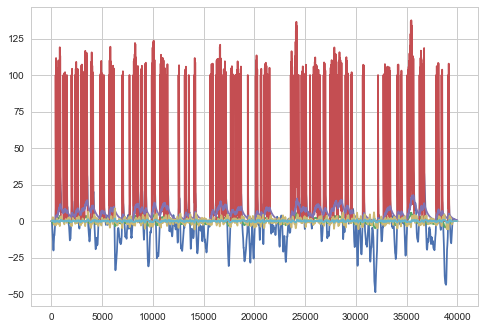

In [6]:
plt.plot(data[0]["states"])
len(data[0]["spike_t"])

In [7]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  priors.uniform(-5,   5),
                  priors.uniform( 0,  20),
                  priors.uniform( 5,  20),
                  priors.uniform( 5,  20),
                  priors.uniform( 5,  20),
                  priors.uniform(100, 300)
                ])

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import log_intensity
    ll = mat_prior(theta)
    if not np.isfinite(ll):
        return -np.inf
    mparams[nparams] = theta
    # precalculate impulse matrix - this is affected by beta, so it has to be in here
    Aexp = matmodel.impulse_matrix(mparams, model_dt, reduced=False)
    lp = 0
    for d in assim_data:
        lci = log_intensity(matstate, Aexp, mparams, d["I_stim"], d["spike_v"], model_dt)
        # NB: if you get overflow errors, adjust bounds to keep lci in a reasonable range (like -100 to 100)
        lpq = np.sum(lci[d["spike_t"]]) - model_dt * np.sum(np.exp(lci))
        if lpq < -1e20:
            return -np.inf
        lp += lpq
    return ll + lp        

In [8]:
# theoretically this is as good as it can get
print(lnpost_dyn(matparams_f))
# and this is our initial state
startparams = np.asarray([[-50,-5,-5,0,5,5,5,100],[200,10,5,20,20,20,20,300]]).T
p0 = startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1])
print(lnpost_dyn(np.median(p0, 0)))

-1664.92148557
-9893.18209724


In [46]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, nsteps/10)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------


/Users/dmeliza/.virtualenvs/akit/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/dmeliza/.virtualenvs/akit/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


    20     -971.96     0:00:21     0:03:29
    40      -735.2     0:00:53     0:03:41
    60     -702.03     0:01:27     0:03:28
    80     -698.92     0:01:57     0:02:59
   100     -698.66     0:02:27     0:02:30
   120     -698.61     0:02:55     0:01:59
   140     -698.61     0:03:24     0:01:29
   160     -698.51     0:03:52     0:00:59
   180     -698.65     0:04:19     0:00:30
   200     -698.41     0:04:47     0:00:01
   201     -698.43     0:04:49     0:00:00


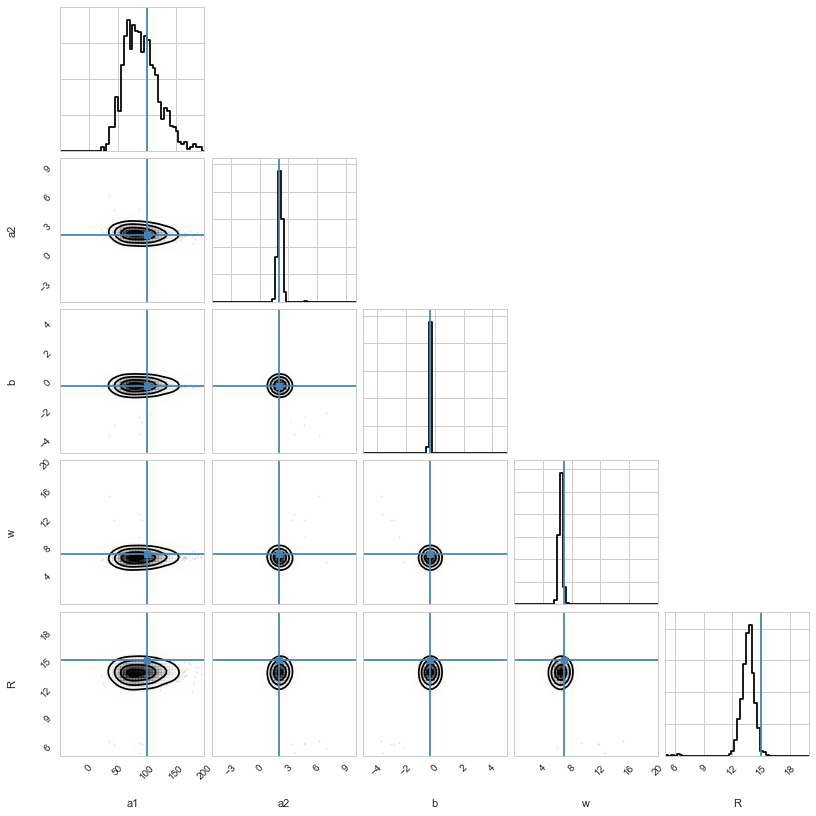

In [47]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w', 'R']
c = corner(pos,
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

In [48]:
# see how well predictions line up
params_guess = np.median(pos, 0)
mparams[:nparams] = params_guess
d = assim_data[0]

print(params_guess)
print(matparams_f)
print(len(S), len(d["spike_t"]))

[ 87.46975169   2.11143661  -0.32726427   6.49924162  13.65943766]
[ 100.     2.    -0.3    7.    15. ]
105 107


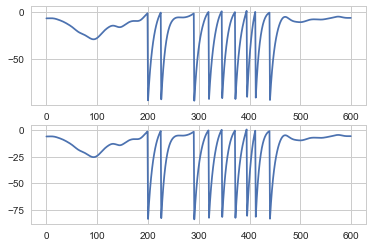

In [34]:
Y, S = matmodel.predict(matstate, mparams, I, model_dt, stochastic=True)
lci_guess = matmodel.log_intensity(matstate, mparams, I, d["spike_v"], model_dt)

plt.plot(d["lci"][:1000])
plt.plot(lci_guess[:1000])
(len(S), len(d["spike_t"]))

In [35]:
(d["lci"] - lci_guess).mean()

-2.3616831428300324